# Setup

In [ ]:
import warnings
import itertools
import os
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

!pip install statsmodels --upgrade

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


# Import Dataset

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Preprocessing

In [ ]:
# let's only read one of the region's power consumptions, to keep this notebook concise
wanliu = pd.read_csv('/content/drive/MyDrive/715_project/PRSA_Data_Wanliu_20130301-20170228.csv', header=0, index_col=0, squeeze=True)

# select columns
wanliu = wanliu[["year", "month", "day", "hour", "PM2.5"]]

# into datetime
wanliu['Datetime']=pd.to_datetime(wanliu[['year','month','day', 'hour']])

# keep only 2 columns
df = wanliu[["Datetime", "PM2.5"]]

# sort by date & time
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)

# display the first couple of rows
df.head()

,Datetime,PM2.5
0,2013-03-01 00:00:00,8.0
1,2013-03-01 01:00:00,9.0
2,2013-03-01 02:00:00,3.0
3,2013-03-01 03:00:00,11.0
4,2013-03-01 04:00:00,3.0


In [ ]:
print('Time period start: {}\nTime period end: {}'.format(df["Datetime"].min(),df["Datetime"].max()))

Time period start: 2013-03-01 00:00:00
Time period end: 2017-02-28 23:00:00


In [ ]:
df.head()

,Datetime,PM2.5
0,2013-03-01 00:00:00,8.0
1,2013-03-01 01:00:00,9.0
2,2013-03-01 02:00:00,3.0
3,2013-03-01 03:00:00,11.0
4,2013-03-01 04:00:00,3.0


## Drop Deduplicates

In [ ]:
# deduplicate, only keeping the last measurement per datetime
df.drop_duplicates(subset='Datetime', keep='last', inplace=True)

## Fill Missing Values

In [ ]:
# let's see if we have a continuous dataset
df = df.set_index('Datetime')
print(f'df.index.freq is set to: {df.index.freq}')

df.index.freq is set to: None


In [ ]:
# custom range
date_range = pd.date_range(start=min(df.index), 
                           end=max(df.index), 
                           freq='H')

In [ ]:
print(f'The difference in length between the custom date range and our dataset is {(len(date_range)-len(df))}:')
print(date_range.difference(df.index))

The difference in length between the custom date range and our dataset is 0:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [ ]:
# this will append the previously missing datetimes, and create null values in our target variable
df = df.reindex(date_range)

# we fill in the blanks with values that lie on a linear curve between existing data points
df['PM2.5'].interpolate(method='linear', inplace=True)

# now we have a neatly continuous datetime index
print(f'The df.index.freq is now: {df.index.freq}, indicating that we no longer have missing instances')

The df.index.freq is now: <Hour>, indicating that we no longer have missing instances


In [ ]:
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 0


In [ ]:
df.head()

,PM2.5
2013-03-01 00:00:00,8.0
2013-03-01 01:00:00,9.0
2013-03-01 02:00:00,3.0
2013-03-01 03:00:00,11.0
2013-03-01 04:00:00,3.0


# Air Quality Index (AQI)

## Daily AQI

In [ ]:
# Revised Breakpoints (µg/m3, 24-hour average)
#def AQI_Breakpoints(i):
    #if i >= 0.0 and i <= 12:
    #    return 'Good'
    #if i >= 12.1 and i <= 35.4:
    #    return 'Moderate'
    #if i >= 35.5 and i <= 55.4:
    #    return 'Unhealthy for Sensitive Groups'
    #if i >= 55.5 and i <= 150.4:
    #    return 'Unhealthy'
    #if i >= 150.5 and i <= 250.4:
    #    return 'Very Unhealthy'
    #if i >= 250.5 and i <= 350.4:
    #    return 'Hazardous'
    #if i >= 350.5 and i <= 500:
    #    return 'Very Hazardous'

In [ ]:
# daily
daily_avg = df.groupby(pd.Grouper(freq='D')).mean()

daily_avg.head()

TypeError: ignored

In [ ]:
# daily_avg['AQI'] = daily_avg['PM2.5'].apply(AQI_Breakpoints)

# print(daily_avg)

In [ ]:
# daily_avg["AQI"].value_counts()

# Train/Test Split

In [ ]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
df['Datetime'] = lbl.fit_transform(df['Datetime'].astype(str))
df['PM2.5'] = lbl.fit_transform(df['PM2.5'].astype(str))

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.10, shuffle=False)

In [ ]:
X_train, y_train = train_df[['Datetime']], train_df[['PM2.5']]
X_test, y_test = test_df[['Datetime']], test_df[['PM2.5']]

In [ ]:
X_train.dtypes

Datetime    int64
dtype: object

# Visualize Data

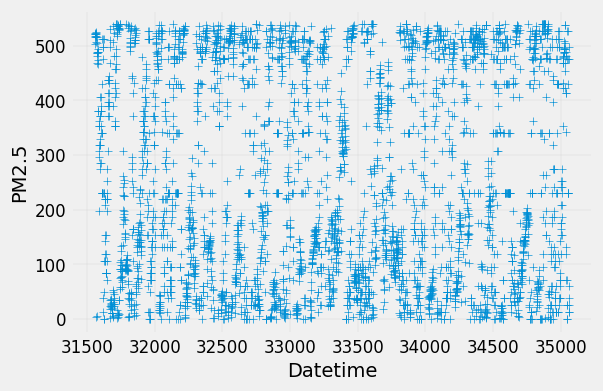

In [ ]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=test_df, x="Datetime", y="PM2.5", marker='+')
plt.grid(linestyle='-', linewidth=0.2)

In [ ]:
from lightgbm import LGBMRegressor
classifiers = {}
for tau in [0.1, 0.5, 0.9]:
    clf = LGBMRegressor(objective='quantile', alpha=tau)
    clf.fit(X_train, y_train)
    preds = pd.DataFrame(clf.predict(X_test), columns = [str(tau)])
    classifiers[str(tau)] = {'clf': clf, 'predictions': preds}

In [ ]:
data = pd.DataFrame({'Datetime': X_test.reset_index()['Datetime'],
              '0.1': classifiers['0.1']['predictions']['0.1'],
              '0.5': classifiers['0.5']['predictions']['0.5'],
              '0.9': classifiers['0.9']['predictions']['0.9'],
              'PM2.5': y_test.reset_index()['PM2.5']})

In [ ]:
data.sample(2)

,Datetime,0.1,0.5,0.9,PM2.5
3239,34796,42.24275,127.324376,483.580384,479
491,32048,42.24275,127.324376,483.580384,513


In [ ]:
melted_data = pd.melt(data, id_vars=['Datetime'])

In [ ]:
melted_data

,Datetime,variable,value
0,31557,0.1,42.24275
1,31558,0.1,42.24275
2,31559,0.1,42.24275
3,31560,0.1,42.24275
4,31561,0.1,42.24275
...,...,...,...
14023,35059,PM2.5,13.00000
14024,35060,PM2.5,60.00000
14025,35061,PM2.5,38.00000
14026,35062,PM2.5,26.00000


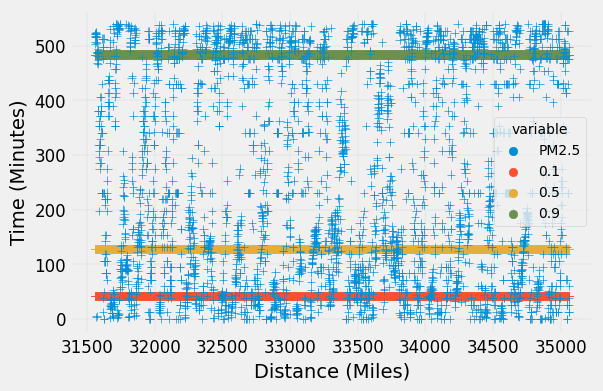

In [ ]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=melted_data, 
                x="Datetime",
                y='value',
                hue='variable',
                hue_order=['PM2.5', '0.1', '0.5', '0.9'],
                marker='+')
plt.grid(linestyle='-', linewidth=0.2)
ylabel = plt.ylabel("Time (Minutes)")
xlabel = plt.xlabel("Distance (Miles)")

In [ ]:
(data['PM2.5'] > data['0.1']).value_counts()

True     2951
False     556
dtype: int64

In [ ]:
(data['PM2.5'] > data['0.5']).value_counts()

True     2249
False    1258
dtype: int64

In [ ]:
(data['PM2.5'] > data['0.9']).value_counts()

False    2743
True      764
dtype: int64